In [1]:
import os 
import time 
from datetime import datetime



import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn import tree
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import datasets 
from sklearn.preprocessing import LabelEncoder
import scipy
import math

from statistics import NormalDist
from visualizations import *
from synthethic_data import *
from bootstrap_data_valuation import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir("RUNS")
current_folder = datetime.now().strftime("RUN %d %b, %H'%M")
os.mkdir(current_folder)
os.chdir(current_folder)

In [3]:
pd.set_option("display.max_rows",None)
np.set_printoptions(threshold=np.inf)

### Help funct

In [4]:
def prepare_df(df, data_noisy):
    df["noise"] = 0 
    df["class"] = 0

    # Workaround the hue paramter in sns.scatterplot()
    df["class_with_noise"] = 0

    for i in noise_idx["index"]:
        df.at[i,"noise"] = 1

    for index, row in data_noisy.iterrows():
        df.at[index,"class"] = row["class"]

    for index, row in df.iterrows():
        if (row["noise"] == 1):
            df.at[index,"class_with_noise"] = 2
        else:
            df.at[index,"class_with_noise"] = row["class"]

    df = df.merge(data_noisy.drop("class",axis=1),how="right",on="index")
    return df

from matplotlib.pyplot import figure
def acc_over_removed_points(df, model, feature_list, target, param_dict=None, ascending=False):
    idx_list = []
    acc_list = []

    for i in range(len(df)-10):
        curent_df = df[i:]
        idx_list.append(i)
        y = curent_df[target]
        x = curent_df[feature_list]

        acc = cross_val_score(model, x, y).mean()
        acc_list.append(acc)
        
    figure(figsize=(10, 10))
    plt.plot(idx_list, acc_list)
    
    if param_dict:
        plt.title(f"Change in model accuracy over points removal\
                  \nn:{param_dict['n']}, overlap:{param_dict['overlap']}, noise:{param_dict['noise']}, tree depth:{param_dict['tree'].max_depth}\
                  \nDescending order: {not ascending}")
    else:
        plt.title(f"Change in model accuracy over points removal\nDescending order: {not ascending}")
    plt.xlabel("Number of points removed")
    plt.ylabel("Accuracy of the model")
    
    plt.savefig(f"Removing points, descending order={not ascending}, change in accuracy.jpg")
    plt.close()
    
def acc_over_removed_points_with_noise(df_list, model, feature_list, target, df_noisy, dataset_name, n_bootstraps, procedure, ascending=False):
    print("Creating performance graphs")
    if (n_bootstraps!=0):
        line = Line2D([0], [0], color="k", lw=2)
        line.set_linestyle("--")
        custom_lines = [Line2D([0], [0], color="k", lw=2),
                        line,
                        Line2D([0], [0], color="b", lw=2),
                        Line2D([0], [0], color="m", lw=2),
                        Line2D([0], [0], color="g", lw=2)]

        line_style1 = ["b-", "m-","g-"]
        line_style2 = ["b--", "m--","g--"]
        index=0
    else:
        line = Line2D([0], [0], color="k", lw=2)
        line.set_linestyle("--")
        custom_lines = [Line2D([0], [0], color="k", lw=2), line]
        
    fig, ax1 = plt.subplots(figsize=(10,10))
    ax2 = ax1.twinx()
    
    for df in df_list: 
        idx_list = []
        acc_list = []
        noise_list = []
        noise_counter = 0
        for i in range(len(df)-10):
            curent_df = df[i:]
            idx_list.append(i)
            y = curent_df[target]
            x = curent_df[feature_list]
            try:
                acc = cross_val_score(model, x, y).mean()
                acc_list.append(acc)
            except:
                print("error -> skipping")
                acc_list.append(acc_list[i-1])
                
            if (len(df_noisy)!=0):
                if ((i!=0) and (df[:i]["index"].iloc[-1] in df_noisy["index"])):
                    noise_counter += 1
                    noise_list.append((noise_counter/len(df_noisy)))
                else:
                    noise_list.append((noise_counter/len(df_noisy)))
        
        if (n_bootstraps!=0):
            ax1.plot(idx_list, acc_list, line_style1[index], label=f"bootstraps: {n_bootstraps[index]}")
            if (len(noise_list)>0):
                ax2.plot(idx_list, noise_list, line_style2[index], label=f"bootstraps: {n_bootstraps[index]}")
            index+=1
        else:
            ax1.plot(idx_list, acc_list, "k-")
            if (len(noise_list)>0):
                ax2.plot(idx_list, noise_list, "r--")
    
    ax1.set_xlabel('Points removed',fontsize=14)
    ax1.set_ylabel('Model accuracy', color='k',fontsize=14)
    ax2.set_ylabel('% of identified noise', color='k',fontsize=14)
    ax1.grid()
    
    if (n_bootstraps!=0):
        plt.legend(custom_lines, ["accuracy change", 
                                 "% of identified noise", 
                                 f"bootstraps: {n_bootstraps[0]}",
                                 f"bootstraps: {n_bootstraps[1]}",
                                 f"bootstraps: {n_bootstraps[2]}",],
                  loc="lower right")
    else: 
        plt.legend(custom_lines, ["accuracy change", 
                                 "% of identified noise"],
                  loc="lower right")

    plt.title(f"Change in model accuracy over points removal-{procedure}\nDataset: {dataset_name}\nTotal number of points: {len(df)}, points with flipped label: {len(df_noisy)}",fontsize=15)
    plt.savefig(f"Removing points, descending order={not ascending}, change in accuracy.jpg")
    plt.close()
    
def compare_datasets(pure_df, df_noisy, df, idx_to_remove, param_dict=None,ascending=False,n_testing=0):
    """ INPUT\n
    >pure_df: DataFrame object with all the points in the dataset\n
    >df_noisy: DataFrame object with all the points in the dataset but with injected artificial noise\n
    >idx_to_remove:indicies of points that were indentified as noise by the data valuation procedure\n
    
    OUTPUT\n
    >Creates three subplots with the whole pure dataset, dataset with the artificial noise, and dataset with
    the removed identified noise"""
    
#     print("Creating dataset comparisons...")
    overlap_list = get_overlap(noise_idx["index"], idx_to_remove)
    df_reduced = df[df["index"].isin(idx_to_remove)==False]

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,6))

    ax1.set_title("Pure data")
    s=sns.scatterplot(x="feature2",
                    y="feature1",
                    hue="class",
                    palette=sns.color_palette("hls",2),
                    data=pure_df,
                    legend="full",
                    ax=ax1)
    
    s.set_xlim(left=pure_df["feature2"].min()-0.5, right=pure_df["feature2"].max()+0.5)
    s.set_ylim(bottom=pure_df["feature1"].min()-0.5, top=pure_df["feature1"].max()+0.5)

    ax2.set_title("Data with artificial noise")
    s=sns.scatterplot(x="feature2",
                    y="feature1",
                    hue="class",
                    palette=sns.color_palette("hls",2),
                    data=df_noisy,
                    legend="full",
                    ax=ax2)
    
    s.set_xlim(left=pure_df["feature2"].min()-0.5, right=pure_df["feature2"].max()+0.5)
    s.set_ylim(bottom=pure_df["feature1"].min()-0.5, top=pure_df["feature1"].max()+0.5)
    try:
        ax3.set_title(f"Descending order={not ascending}\nPoints removed: {len(pure_df)-len(df_reduced)-n_testing},\nfrom which {len(overlap_list)} were injected noise")
        s = sns.scatterplot(x="feature2",
                        y="feature1",
                        hue="class",
                        palette=sns.color_palette("hls",2),
                        data=df_reduced,
                        legend="full",
                        ax=ax3)

        s.set_xlim(left=pure_df["feature2"].min()-0.5, right=pure_df["feature2"].max()+0.5)
        s.set_ylim(bottom=pure_df["feature1"].min()-0.5, top=pure_df["feature1"].max()+0.5)
    except:
        pass

    if param_dict:
        fig.suptitle(f"Parameters: n:{param_dict['n']}, overlap:{param_dict['overlap']}, noise:{param_dict['noise']}, tree depth:{param_dict['tree'].max_depth}")
        fig.savefig(
            f"{param_dict['n']}-{len(idx_to_remove)}_{param_dict['noise']}_{param_dict['overlap']}_{param_dict['tree'].max_depth}"
            f"_descending={not ascending}.jpg")
    else:
        fig.suptitle(f"Parameters not given")
        fig.savefig("Dataset after reduction.jpg")
    
    plt.close(fig)
    

In [7]:
def produce_df(measure, folds, point_valuation, n_points):
    columns = [i for i in range(len(folds))]
    df = pd.DataFrame(np.nan,
                      index=range(n_points),
                      columns=columns)

    for fold in range(len(folds)):
        for split in ["train","test"]:
            points_idx = folds[fold][split].index
            for point in points_idx:
                try:
                    df.at[point, fold] = np.array(point_valuation[fold][point][measure]).mean()
                except:
                    pass
    df[measure] = df.mean(axis=1)
    df["index"] = df.index
    return df

def produce_df_bootstrapping_only(measure, point_valuation, n_points):
    
    df = pd.DataFrame(np.nan,
                      index=range(n_points),
                      columns=[measure])
    
    for point in point_valuation.keys():
        df.at[point, measure] = np.array(point_valuation[point][measure]).mean()

    df["index"] = df.index
    return df


def create_plot(performance_dict, measure, dataset, total_points, order):  
    fig, ax1 = plt.subplots(figsize=(10,10))
    for n_b in performance_dict.keys():
        current_dict = performance_dict[n_b][measure][order]
        ax1.plot(current_dict.keys(), current_dict.values(), label=f"bootstraps: {n_b}")
    
    ax1.set_xlabel("Number of points removed")
    ax1.set_ylabel("Accuracy change")
    ax1.grid()
    ax1.legend()
    fig.suptitle(f"Change in accuracy over points removal, procedure: Bootstrap Data Valuation\
                 \nDataset: {dataset} \nTotal points: {total_points} \nmeasure: {measure}")
    fig.savefig(f"{measure}.jpg")
    plt.close(fig)
    
# Used for: BDV with folds, real data 
def create_accuracy_removal_plots(measures, features, target, dataset, n_points, df_complete, dataset_type, model, bootstraps_dict, param_dict=None):
    folds_performance = {}

    points_keys = n_points - (n_points/len(folds.keys()))
    for n_b in n_bootstraps:
        folds_performance[n_b] = {}
        print(f"\nNumber of bootstraps: {n_b}")
        for measure in measures:
            print(f"Measure: {measure}")

            df = produce_df(measure, bootstraps_dict[n_b]["folds"], bootstraps_dict[n_b]["point_valuation"], n_points)
            df = df.merge(df_complete, on="index")
            folds_performance[n_b][measure] = {}
            for o in [True, False]:
                if o:
                    order = "ascending"
                    folds_performance[n_b][measure][order] = {}

                else:
                    order = "descending"
                    folds_performance[n_b][measure][order] = {}


                # init dict that will hold peformance for removing i points from a specific fold 
                for index in range(int(points_keys*0.90)):
                    folds_performance[n_b][measure][order][index] = []

                # remove points one by one and check the model performance
                for fold in bootstraps_dict[n_b]["folds"].keys():
                    current_fold = bootstraps_dict[n_b]["folds"][fold]

                    train_idx = current_fold["train"].index
                    test_idx = current_fold["test"].index

                    X_test = df.loc[test_idx][features]
                    Y_test = df.loc[test_idx][target]

                    train_idx_sorted = df.loc[train_idx].sort_values(by=fold, ascending=o).index
                    for i in range(len(folds_performance[n_b][measure][order].keys())):
                        current_df = df.loc[train_idx_sorted[i:]]

                        X_train = current_df[features]
                        Y_train = current_df[target]

                        model.fit(X_train, Y_train)
                        Y_pred = model.predict(X_test)
                        acc = accuracy_score(Y_test, Y_pred)

                        folds_performance[n_b][measure][order][i].append(acc)

                # transform the results into a mean
                for i in folds_performance[n_b][measure][order]:
                    avg = np.array(folds_performance[n_b][measure][order][i]).mean()
                    folds_performance[n_b][measure][order][i] = avg

    
    for measure in measures:
        os.mkdir(measure)
        os.chdir(measure)
        for order in ["ascending", "descending"]:
            if order=="ascending":
                    order = "ascending"
                    os.mkdir(order)
                    os.chdir(order)
            else:
                order = "descending"
                os.mkdir(order)
                os.chdir(order)
            create_plot(folds_performance, measure, dataset, n_points, order)
            os.chdir("../")
        os.chdir("../")
            

                    
# Used for: only bootstrapping, synthetic data 
def create_accuracy_removal_plots_bootstrapping_only(bootstraps_dict, measures, n_points, df_original, folds, model,param_dict):
    folds_performance = {}
    kf = KFold(n_splits=folds)
    testing_points = n_points/kf.get_n_splits()
    training_points = n_points - (n_points/kf.get_n_splits())
    fractions = np.linspace(0,1,11)
    for n_b in bootstraps_dict.keys():
        folds_performance[n_b] = {}
        print(f"\nNumber of bootstraps: {n_b}")
        
        for measure in measures:
            print(f"Measure: {measure}")
            df = produce_df_bootstrapping_only(measure, bootstraps_dict[n_b]["point_valuation"], n_points)
            df = df.merge(df_original, on="index")
            folds_performance[n_b][measure] = {}
            
            for o in [True, False]:
                if o:
                    order = "ascending"
                    folds_performance[n_b][measure][order] = {}

                else:
                    order = "descending"
                    folds_performance[n_b][measure][order] = {}


                # init dict that will hold peformance for removing i points from a specific fold 
                for index in range(int(training_points*0.90)):
                    folds_performance[n_b][measure][order][index] = []
                
                fold_index = 0
        #     remove points one by one and check the model performance
                for train_index, test_index in kf.split(df["index"]):
                    test_df = df.loc[test_index]

                    Y_test = df.loc[test_index][target]
                    X_test = df.loc[test_index][features]

                    train_idx_sorted = df.loc[train_index].sort_values(by=measure, ascending=o).index
                    for i in range(int(len(train_index)*0.90)):
                        current_df = df.loc[train_idx_sorted[i:]]

                        X_train = current_df[features]
                        Y_train = current_df[target]

                        model.fit(X_train, Y_train)
                        Y_pred = model.predict(X_test)
                        acc = accuracy_score(Y_test, Y_pred)

                        folds_performance[n_b][measure][order][i].append(acc)
                    
                    fold_index+=1


                # transform the results into a mean
                for i in folds_performance[n_b][measure][order]:
                    avg_acc = np.array(folds_performance[n_b][measure][order][i]).mean()
                    folds_performance[n_b][measure][order][i] = avg_acc
    
    os.mkdir("Folds averaged")
    os.chdir("Folds averaged")
    for measure in measures:
        os.mkdir(measure)
        os.chdir(measure)
        for order in ["ascending", "descending"]:
            if order=="ascending":
                    order = "ascending"
                    os.mkdir(order)
                    os.chdir(order)
            else:
                order = "descending"
                os.mkdir(order)
                os.chdir(order)
                
            create_plot(folds_performance, measure, "Synthetic", n_points, order)
            os.chdir("../")
        os.chdir("../")
    os.chdir("../")
        
    return folds_performance

## LOO Functions

In [8]:
def LOO(dataset, features, target, model):

    X = dataset[features]
    y = dataset[target]
    
    loo = LeaveOneOut()
    df = dataset.copy()
    df['diff'] = 0.0

    for train_index, test_index in loo.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        acc = cross_val_score(model, X, y).mean()
        acc_LOO = cross_val_score(model, X_train, y_train).mean()
        diff = acc - acc_LOO

        df.at[test_index[0],"diff"] = diff
    
    return df
    
def LOO_kfold(df, target, features, model, folds=10):
    kf = KFold(n_splits=folds)
    folds_performance = {}
    n_points = len(df)
    training_points = n_points - (n_points/kf.get_n_splits())

    for o in [True, False]:
        if o:
            order = "ascending"
        else:
            order = "descending"
            
        folds_performance[order] = {}
            
        for index in range(int(training_points*0.90)):
            folds_performance[order][index] = []
                
        for train_index, test_index in kf.split(df["index"]):
            test_df = df.loc[test_index]

            Y_test = df.loc[test_index][target]
            X_test = df.loc[test_index][features]

            train_idx_sorted = df.loc[train_index].sort_values(by="diff", ascending=o).index
            for i in range(len(folds_performance[order].keys())):
                current_df = df.loc[train_idx_sorted[i:]]

                X_train = current_df[features]
                Y_train = current_df[target]

                model.fit(X_train, Y_train)
                Y_pred = model.predict(X_test)
                acc = accuracy_score(Y_test, Y_pred)
                folds_performance[order][i].append(acc)
        
        # transform the results into a mean
        for i in folds_performance[order]:
            avg_acc = np.array(folds_performance[order][i]).mean()
            folds_performance[order][i] = avg_acc
        

    for order in ["ascending", "descending"]:
        if order=="ascending":
            order = "ascending"
            os.mkdir(order)
            os.chdir(order)
        else:
            order = "descending"
            os.mkdir(order)
            os.chdir(order)

        create_plot_LOO(folds_performance, "Synthetic", n_points, order)
        os.chdir("../")
    

# folds_performance[n_b][measure][order][i]
def create_plot_LOO(performance_dict, dataset, total_points, order):  
    fig, ax1 = plt.subplots(figsize=(10,10))

    current_dict = performance_dict[order]
    ax1.plot(current_dict.keys(), current_dict.values())
    
    ax1.set_xlabel("Number of points removed")
    ax1.set_ylabel("Accuracy change")
    ax1.grid()
    fig.suptitle(f"Change in accuracy over points removal, procedure: LOO\
                 \nDataset: {dataset} \nTotal points: {total_points}")
    fig.savefig(f"LOO_{order}.jpg")

In [20]:
n=100
noise=0.0
overlap=0.25

k=1
n_bootstraps=[100]
n_folds=1

measures = ["inside", 
            "outside_biased", "outside_unbiased", 
            "difference_biased", "difference_unbiased"]

target = ["class"]
features = ["feature1","feature2"]


classifier_single = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         max_depth=1,
                                         random_state=0)
classifier_multi = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         random_state=0)



df_pure, df_noisy, df_red_noise, noise_idx = prepare_data(n,
                                                          noise,
                                                          overlap)


            
valuation = bootstrap_data_valuation(df_noisy, 
                                     classifier_single, 
                                     "class",
                                     n_bootstraps=100,
                                     n_folds=1)
df = valuation.data_valuation()


Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 2.356698513031006 seconds --- 



## Load the data

In [8]:
data = pd.read_csv("C:/Users/Michauu/BTR code/datasets/diabetes.csv")
heart = pd.read_csv("C:/Users/Michauu/BTR code/datasets/heart.csv")
haberman = pd.read_csv("C:/Users/Michauu/BTR code/datasets/haberman.data", names=["age","year","pnodes","class"])
banknotes = pd.read_csv("C:/Users/Michauu/BTR code/datasets/data_banknote_authentication.txt", names=["variance", "skewness","curtosis","entropy","class"])
cancer = pd.read_csv("C:/Users/Michauu/BTR code/datasets/breast-cancer-wisconsin.data",names=["index","a1","a2", "a3","a4","a5","a6","a7", "a8","a9","class"])

#### Data preprocessing

#### Haberman

In [9]:
haberman["index"] = haberman.index

#### Cancer

In [11]:
cancer["index"] = cancer.index
cancer = cancer.drop(cancer[cancer["a6"]=="?"].index)
cancer = cancer.reset_index(drop=True)
cancer["index"] = cancer.index
cancer["a6"].astype("int64")

cancer["class"] = cancer["class"].apply(lambda x: 0 if x==2 else 1)

In [12]:
len(cancer)

683

#### Banknotes

In [13]:
banknotes["index"] = banknotes.index

#### Heart

In [14]:
len(heart[heart.isna().any(axis=1)])

621

In [14]:
# Encoding of non-integer variables
sex_le = LabelEncoder()
cp_le = LabelEncoder()
fbs_le = LabelEncoder()
restecg_le = LabelEncoder()
exang_le = LabelEncoder()
slope_le = LabelEncoder()
thal_le = LabelEncoder()

heart["sex"] = sex_le.fit_transform(heart["sex"])
heart["cp"] = cp_le.fit_transform(heart["cp"])
heart["fbs"] = fbs_le.fit_transform(heart["fbs"])
heart["restecg"] = restecg_le.fit_transform(heart["restecg"])
heart["exang"] = exang_le.fit_transform(heart["exang"])
heart["slope"] = slope_le.fit_transform(heart["slope"])
heart["thal"] = thal_le.fit_transform(heart["thal"])


# Drop nans 
heart = heart.drop(["dataset","ca"],axis=1)
heart = heart.drop(heart[heart.isna().any(axis=1)].index)

# class 1-4 is presence of the disease
heart = heart.rename(columns={"num":"class","id":"index"})
heart["class"] = heart["class"].apply(lambda x: 0 if x==0 else 1)

# Reset index 
heart = heart.reset_index(drop=True)
heart["index"] = heart.index

In [21]:
cancer

index  a1  a2  a3  a4  a5  a6  a7  a8  a9  class
0        0   5   1   1   1   2   1   3   1   1      0
1        1   5   4   4   5   7  10   3   2   1      0
2        2   3   1   1   1   2   2   3   1   1      0
3        3   6   8   8   1   3   4   3   7   1      0
4        4   4   1   1   3   2   1   3   1   1      0
5        5   8  10  10   8   7  10   9   7   1      1
6        6   1   1   1   1   2  10   3   1   1      0
7        7   2   1   2   1   2   1   3   1   1      0
8        8   2   1   1   1   2   1   1   1   5      0
9        9   4   2   1   1   2   1   2   1   1      0
10      10   1   1   1   1   1   1   3   1   1      0
11      11   2   1   1   1   2   1   2   1   1      0
12      12   5   3   3   3   2   3   4   4   1      1
13      13   1   1   1   1   2   3   3   1   1      0
14      14   8   7   5  10   7   9   5   5   4      1
15      15   7   4   6   4   6   1   4   3   1      1
16      16   4   1   1   1   2   1   2   1   1      0
17      17   4   1   1   1   2   1   3   1   1      0
18      18  10   7   7   6   4  10   4   1   2      1
19      19   6   1   1   1   2   1   3   1   1      0
20      20   7   3   2  10   5  10   5   4   4      1
21      21  10   5   5   3   6   7   7  10   1      1
22      22   3   1   1   1   2   1   2   1   1      0
23      23   1   1   1   1   2   1   3   1   1      0
24      24   5   2   3   4   2   7   3   6   1      1
25      25   3   2   1   1   1   1   2   1   1      0
26      26   5   1   1   1   2   1   2   1   1      0
27      27   2   1   1   1   2   1   2   1   1      0
28      28   1   1   3   1   2   1   1   1   1      0
29      29   3   1   1   1   1   1   2   1   1      0
30      30   2   1   1   1   2   1   3   1   1      0
31      31  10   7   7   3   8   5   7   4   3      1
32      32   2   1   1   2   2   1   3   1   1      0
33      33   3   1   2   1   2   1   2   1   1      0
34      34   2   1   1   1   2   1   2   1   1      0
35      35  10  10  10   8   6   1   8   9   1      1
36      36   6   2   1   1   1   1   7   1   1      0
37      37   5   4   4   9   2  10   5   6   1      1
38      38   2   5   3   3   6   7   7   5   1      1
39      39  10   4   3   1   3   3   6   5   2      1
40      40   6  10  10   2   8  10   7   3   3      1
41      41   5   6   5   6  10   1   3   1   1      1
42      42  10  10  10   4   8   1   8  10   1      1
43      43   1   1   1   1   2   1   2   1   2      0
44      44   3   7   7   4   4   9   4   8   1      1
45      45   1   1   1   1   2   1   2   1   1      0
46      46   4   1   1   3   2   1   3   1   1      0
47      47   7   8   7   2   4   8   3   8   2      1
48      48   9   5   8   1   2   3   2   1   5      1
49      49   5   3   3   4   2   4   3   4   1      1
50      50  10   3   6   2   3   5   4  10   2      1
51      51   5   5   5   8  10   8   7   3   7      1
52      52  10   5   5   6   8   8   7   1   1      1
53      53  10   6   6   3   4   5   3   6   1      1
54      54   8  10  10   1   3   6   3   9   1      1
55      55   8   2   4   1   5   1   5   4   4      1
56      56   5   2   3   1   6  10   5   1   1      1
57      57   9   5   5   2   2   2   5   1   1      1
58      58   5   3   5   5   3   3   4  10   1      1
59      59   1   1   1   1   2   2   2   1   1      0
60      60   9  10  10   1  10   8   3   3   1      1
61      61   6   3   4   1   5   2   3   9   1      1
62      62   1   1   1   1   2   1   2   1   1      0
63      63  10   4   2   1   3   2   4   3  10      1
64      64   4   1   1   1   2   1   3   1   1      0
65      65   5   3   4   1   8  10   4   9   1      1
66      66   8   3   8   3   4   9   8   9   8      1
67      67   1   1   1   1   2   1   3   2   1      0
68      68   5   1   3   1   2   1   2   1   1      0
69      69   6  10   2   8  10   2   7   8  10      1
70      70   1   3   3   2   2   1   7   2   1      0
71      71   9   4   5  10   6  10   4   8   1      1
72      72  10   6   4   1   3   4   3   2   3      1
73      7

## Testing - real datasets with artificial noise

In [15]:
classifier_singel = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         max_depth=1,
                                         random_state=0)

classifier_multi = tree.DecisionTreeClassifier(criterion = 'entropy',
                                         min_samples_leaf = 1,
                                         random_state=0)

models = [classifier_singel, classifier_multi]
noises = [0.05, 0.15, 0.25]

## Haberman dataset

## LOO

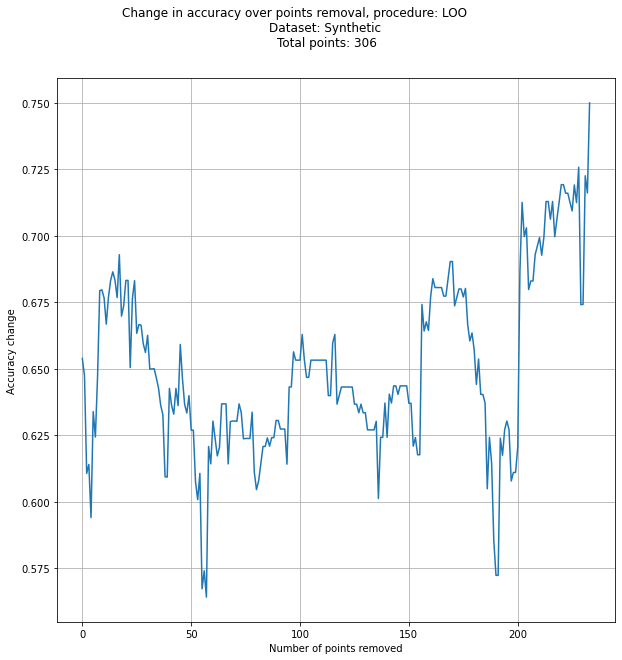

In [16]:
os.mkdir("Haberman")
os.chdir("Haberman")

features = haberman.columns[:3].tolist()
target = "class"
dataset="Haberman"

os.mkdir("LOO")
os.chdir("LOO")

for model in models:
    os.mkdir(f"model={model.max_depth}")
    os.chdir(f"model={model.max_depth}")
    
    df = LOO(haberman, features, target, model)
    LOO_kfold(df, target, features, model)
    os.chdir("../")
os.chdir("../")

## Bootstrap Data Valuation

Fold: 0
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 9.432487487792969 seconds --- 

Fold: 1
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 9.397860288619995 seconds --- 

Fold: 2
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 9.97632122039795 seconds --- 

Fold: 3
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 10.529061555862427 seconds --- 

Fold: 4
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset numb

Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 8.850324392318726 seconds --- 

Fold: 8
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 8.822668075561523 seconds --- 

Fold: 9
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 8.818390607833862 seconds --- 

Fold: 0
Subset number: 0
Subset number: 100
Subset number: 200
Subset number: 300
Subset number: 400
Subset number: 500
Subset number: 600
Subset number: 700
Subset number: 800
Subset number: 900
--- 97.03741335868835 seconds --- 

Fold: 1
Subset number: 0
Subset number: 100
Subset number: 200
Subset number: 300
Subset number: 400
Subset number: 500
Subset number: 600
Subset number: 700
Subset number: 800
S

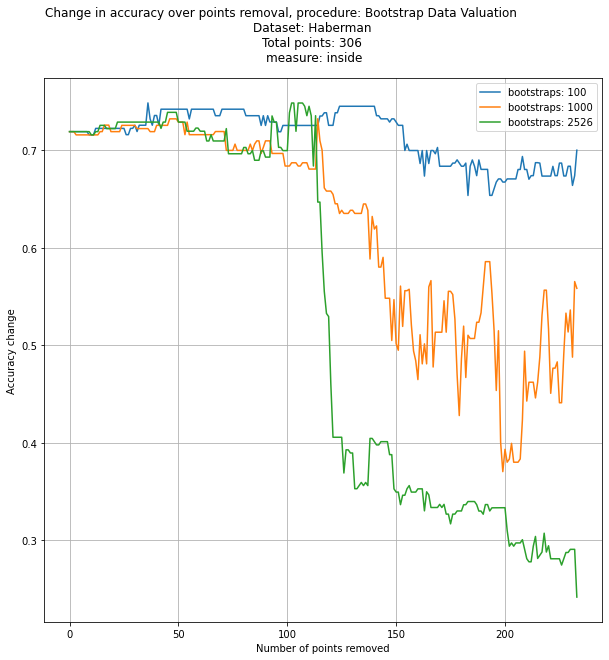

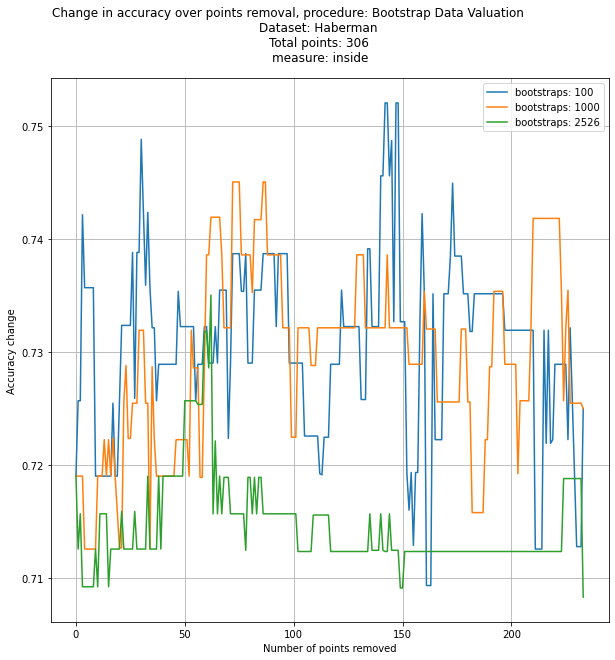

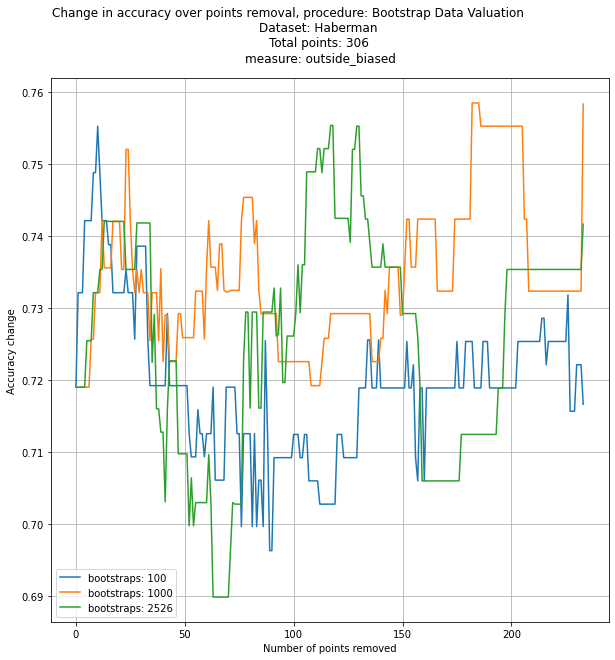

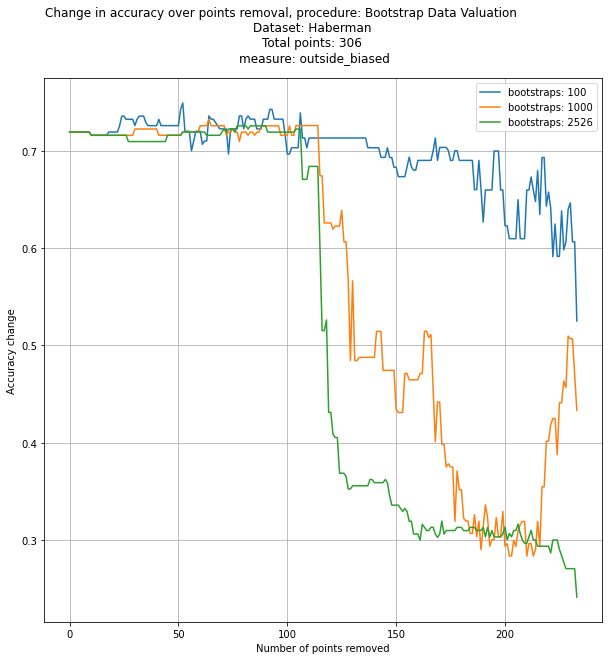

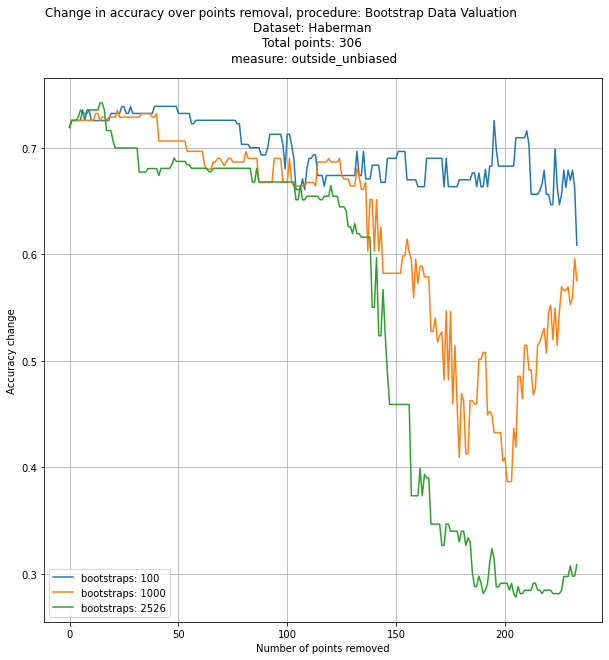

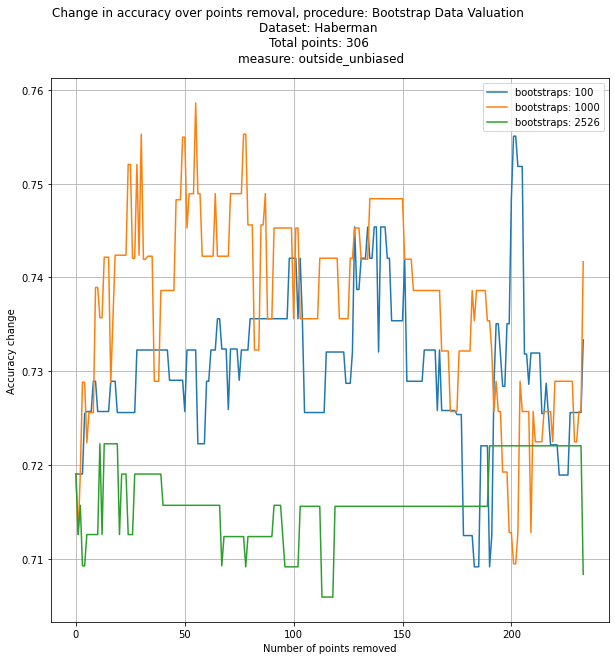

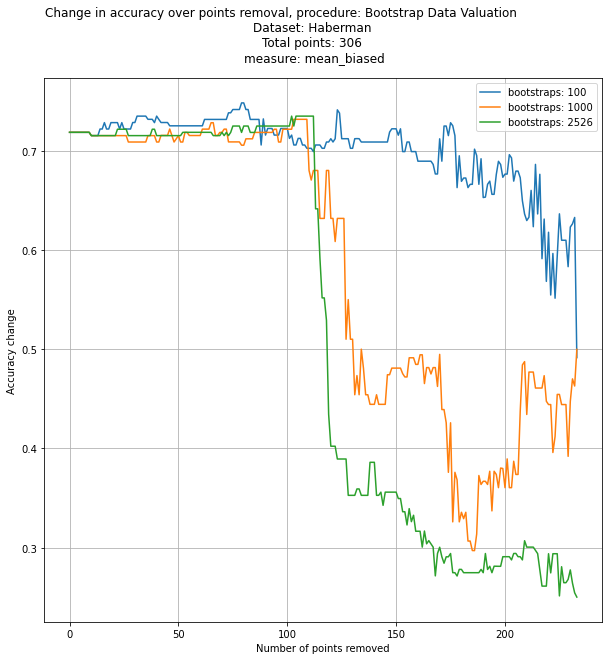

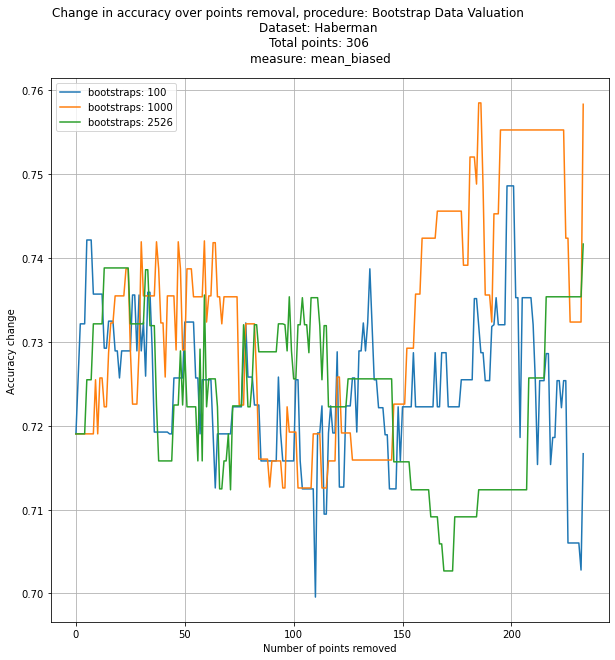

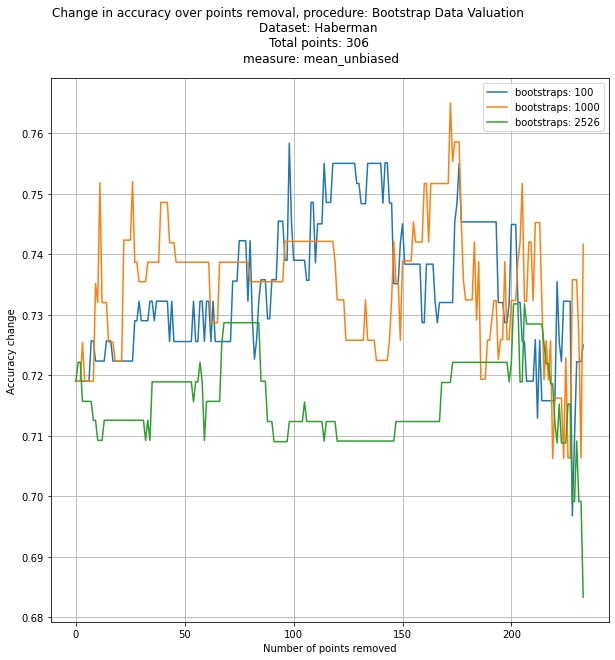

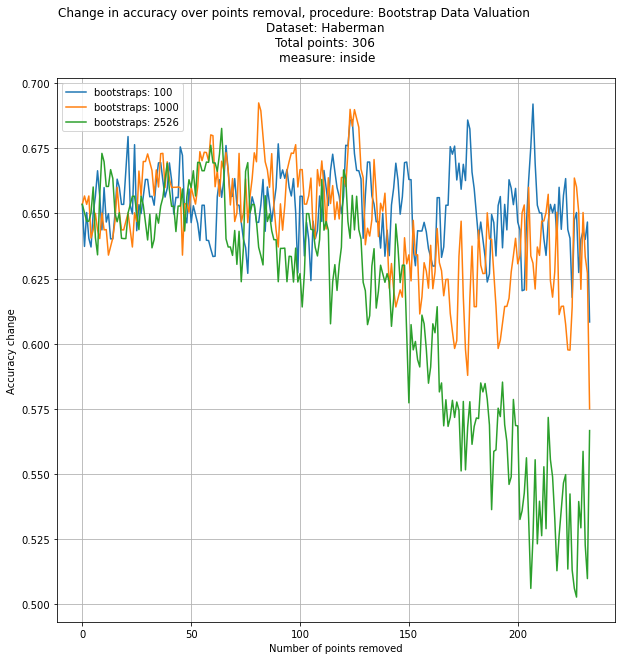

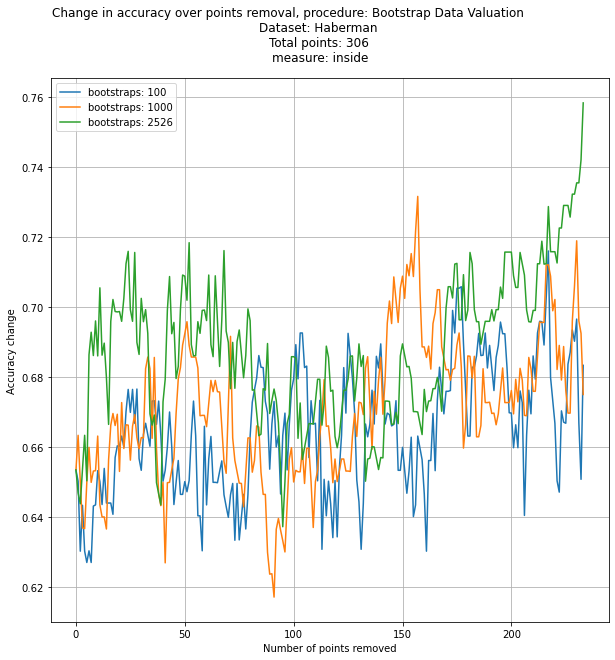

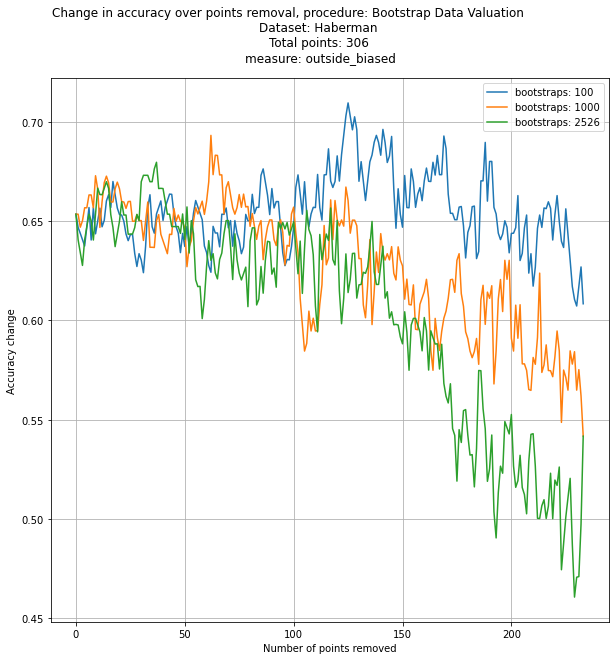

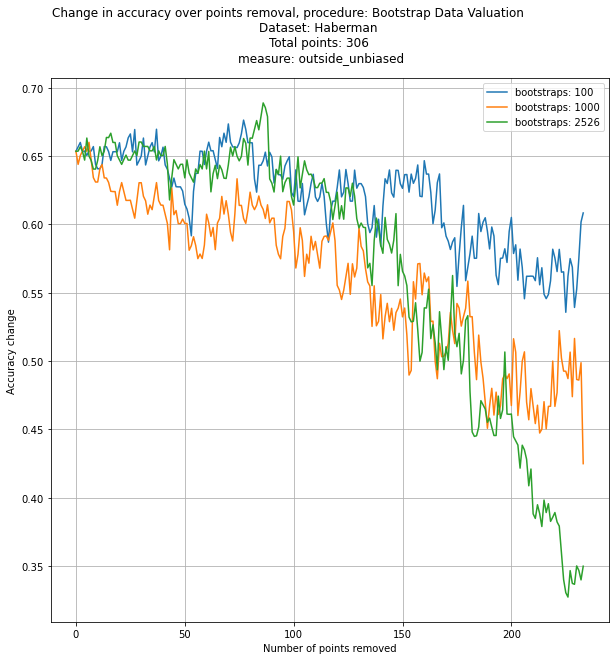

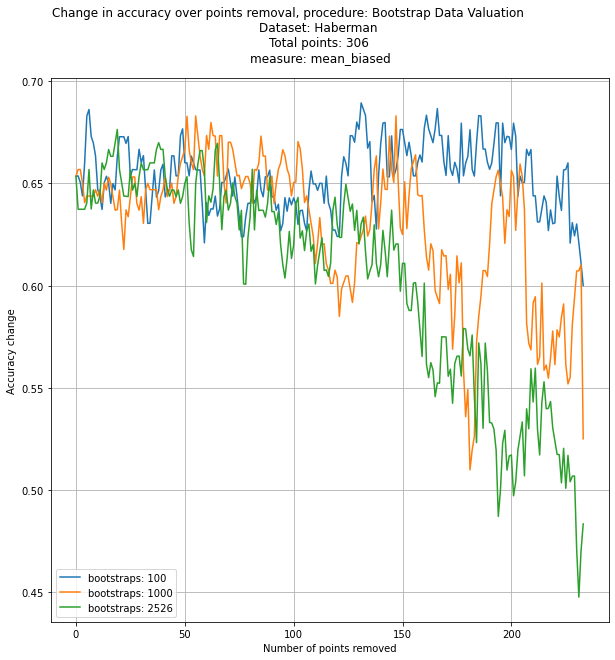

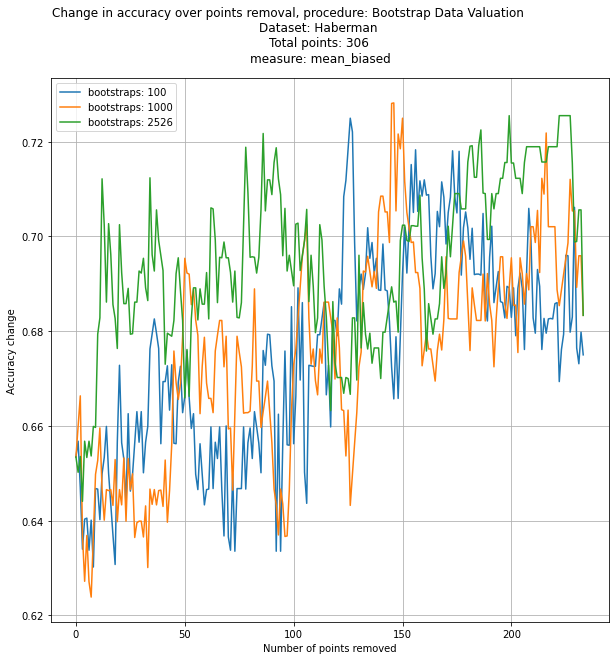

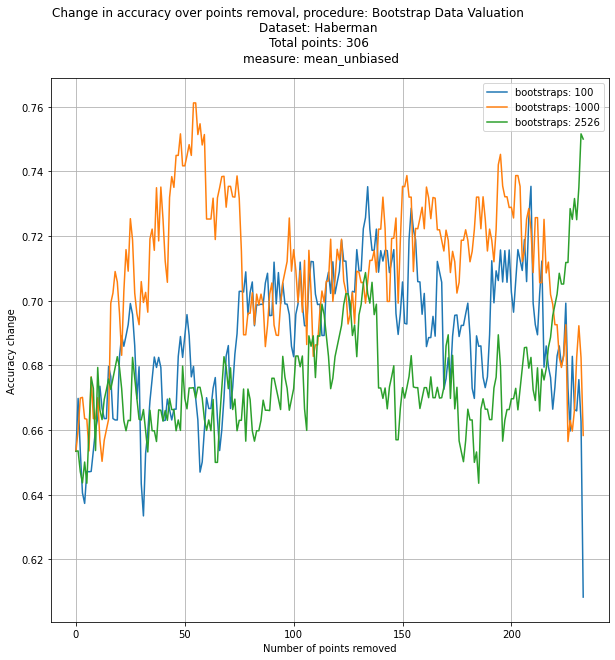

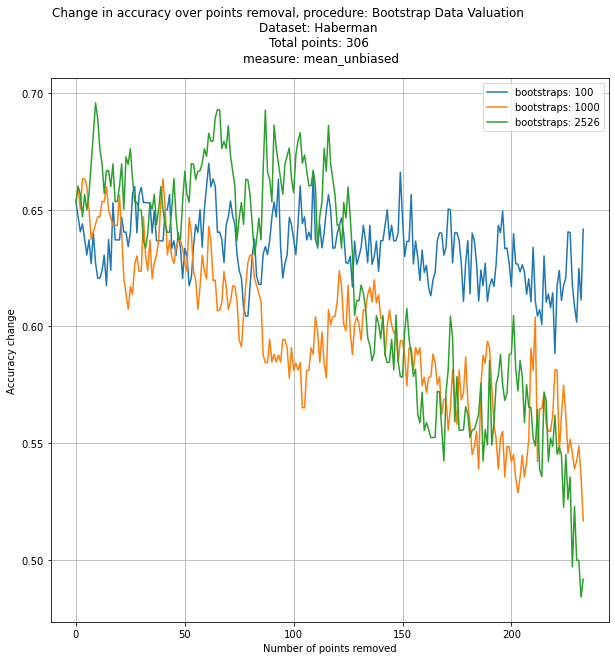

In [17]:
os.mkdir("Haberman")
os.chdir("Haberman")

features = haberman.columns[:3].tolist()
target = "class"
dataset="Haberman"

measures = ["inside","outside_biased","outside_unbiased", "mean_biased", "mean_unbiased"]


n_points = len(haberman)
n_bootstraps=[100,1000,int(n_points*math.log(n_points,2))]
bootstraps_dict = {}

for model in models:
    os.mkdir(f"model={model.max_depth}")
    os.chdir(f"model={model.max_depth}")
    for n_b in n_bootstraps:
        valuation = bootstrap_data_valuation(haberman,
                                             model,
                                             target,
                                             n_bootstraps=n_b,
                                             n_folds=10)
        dfs = valuation.perform_kfold()
        point_valuation = valuation.point_valuation
        folds = valuation.folds
        bootstraps_dict[n_b] = {"point_valuation":point_valuation,
                                "folds": folds}

    create_accuracy_removal_plots(measures, 
                                  features, 
                                  target, 
                                  dataset, 
                                  n_points, 
                                  haberman, 
                                  "real",
                                  model,
                                  bootstraps_dict,
                                  param_dict=None)
    os.chdir("../")
os.chdir("../")

## Cancer dataset

## LOO

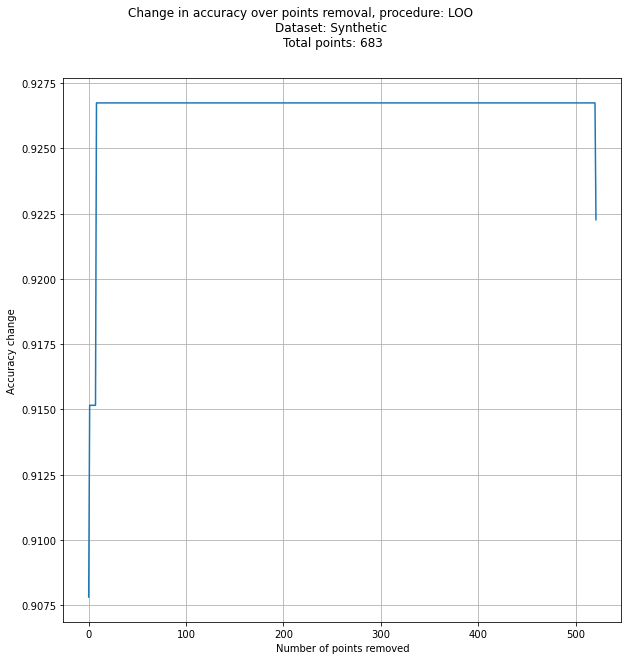

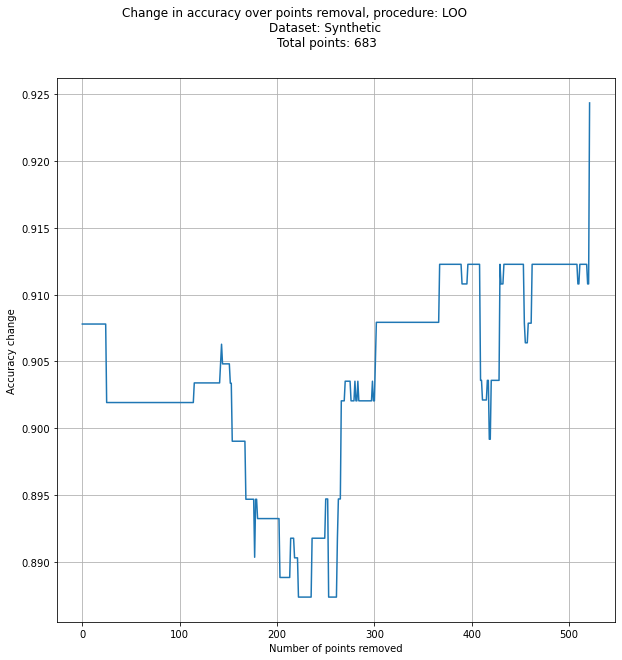

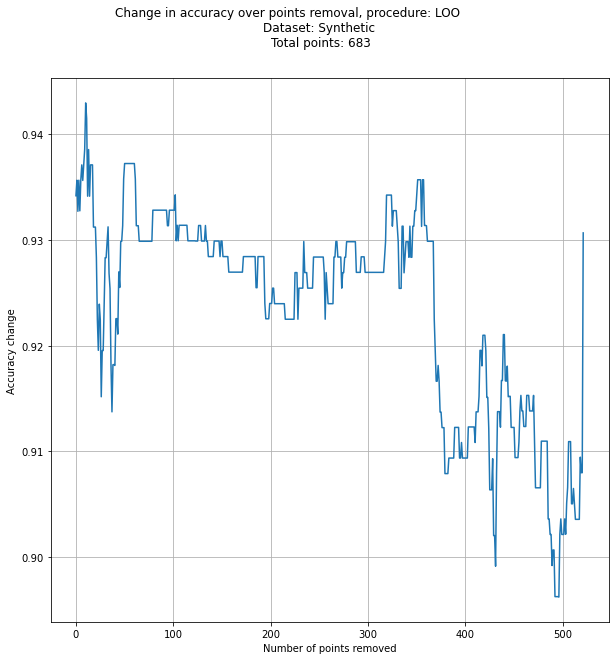

In [17]:
os.mkdir("Cancer")
os.chdir("Cancer")

features = cancer.columns[1:10].tolist()
target = "class"
dataset="Cancer"

os.mkdir("LOO")
os.chdir("LOO")

for model in models:
    os.mkdir(f"model={model.max_depth}")
    os.chdir(f"model={model.max_depth}")
    
    df = LOO(cancer, features, target, model)
    LOO_kfold(df, target, features, model)
    os.chdir("../")
os.chdir("../")
os.chdir("../")

## Bootstrap Data Valuation

Fold: 0
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 20.23388671875 seconds --- 

Fold: 1
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 20.375473976135254 seconds --- 

Fold: 2
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 21.201236486434937 seconds --- 

Fold: 3
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 22.92369055747986 seconds --- 

Fold: 4
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset numbe

Subset number: 4000
Subset number: 4500
Subset number: 4501
Subset number: 5000
Subset number: 5144
Subset number: 5500
Subset number: 5787
Subset number: 6000
--- 2583.358454465866 seconds --- 

Fold: 8
Subset number: 0
Subset number: 500
Subset number: 643
Subset number: 1000
Subset number: 1286
Subset number: 1500
Subset number: 1929
Subset number: 2000
Subset number: 2500
Subset number: 2572
Subset number: 3000
Subset number: 3215
Subset number: 3500
Subset number: 3858
Subset number: 4000
Subset number: 4500
Subset number: 4501
Subset number: 5000
Subset number: 5144
Subset number: 5500
Subset number: 5787
Subset number: 6000
--- 2863.409507036209 seconds --- 

Fold: 9
Subset number: 0
Subset number: 500
Subset number: 643
Subset number: 1000
Subset number: 1286
Subset number: 1500
Subset number: 1929
Subset number: 2000
Subset number: 2500
Subset number: 2572
Subset number: 3000
Subset number: 3215
Subset number: 3500
Subset number: 3858
Subset number: 4000
Subset number: 4500
Su

Subset number: 2500
Subset number: 2572
Subset number: 3000
Subset number: 3215
Subset number: 3500
Subset number: 3858
Subset number: 4000
Subset number: 4500
Subset number: 4501
Subset number: 5000
Subset number: 5144
Subset number: 5500
Subset number: 5787
Subset number: 6000
--- 2288.1392776966095 seconds --- 

Fold: 5
Subset number: 0
Subset number: 500
Subset number: 643
Subset number: 1000
Subset number: 1286
Subset number: 1500
Subset number: 1929
Subset number: 2000
Subset number: 2500
Subset number: 2572
Subset number: 3000
Subset number: 3215
Subset number: 3500
Subset number: 3858
Subset number: 4000
Subset number: 4500
Subset number: 4501
Subset number: 5000
Subset number: 5144
Subset number: 5500
Subset number: 5787
Subset number: 6000
--- 2280.4366385936737 seconds --- 

Fold: 6
Subset number: 0
Subset number: 500
Subset number: 643
Subset number: 1000
Subset number: 1286
Subset number: 1500
Subset number: 1929
Subset number: 2000
Subset number: 2500
Subset number: 2572


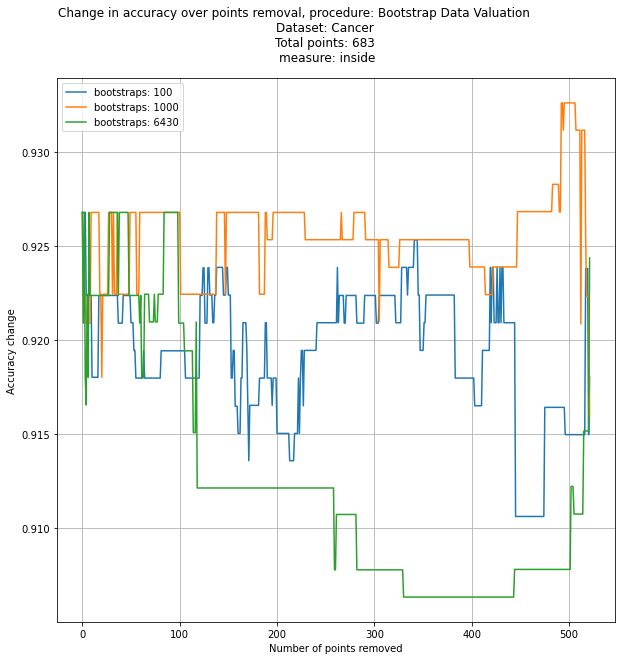

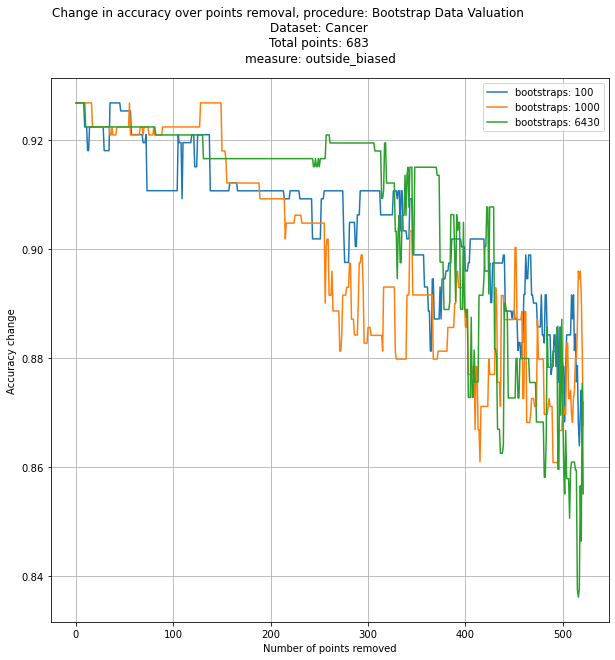

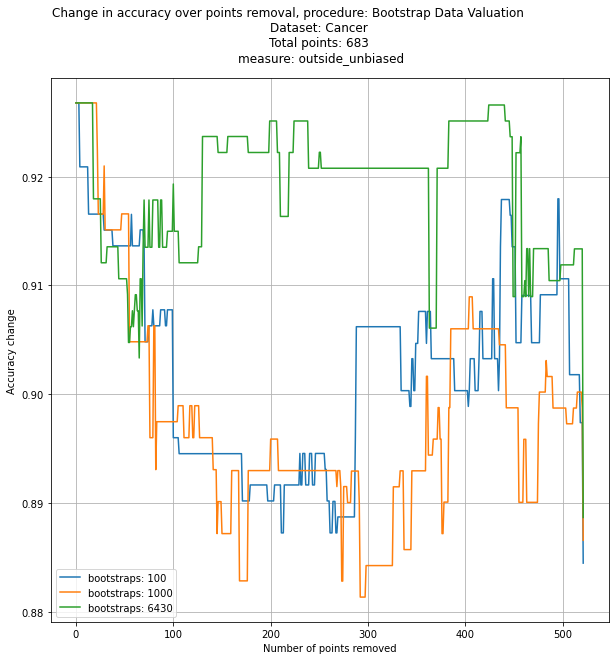

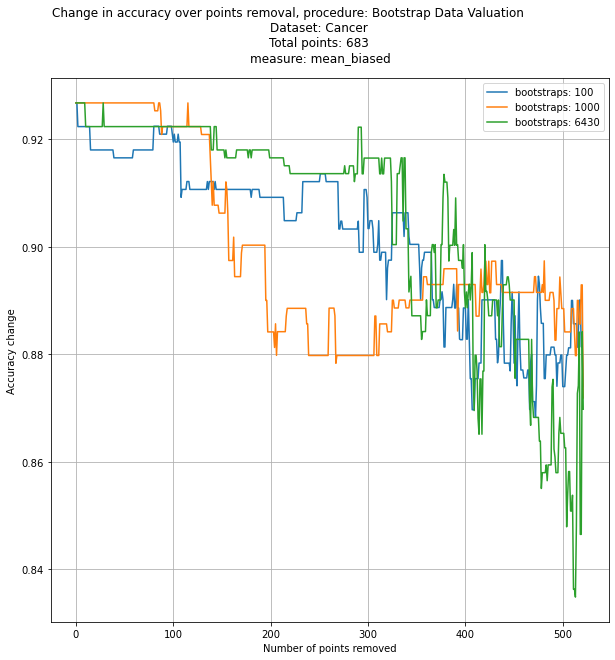

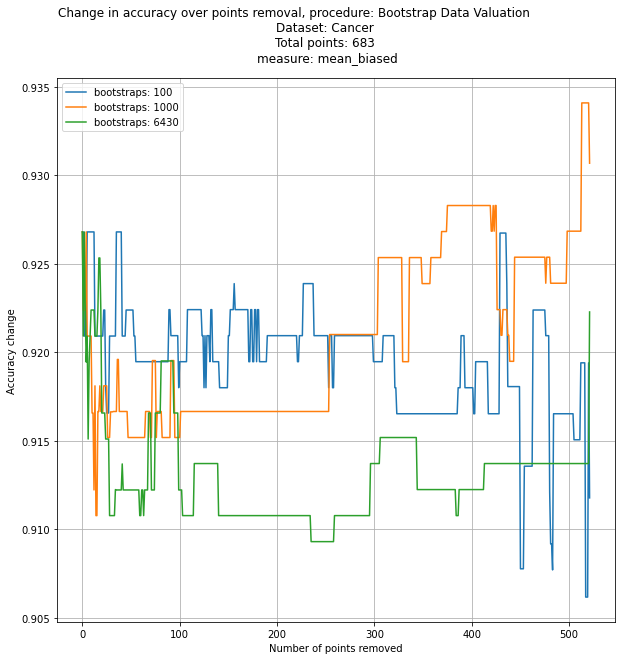

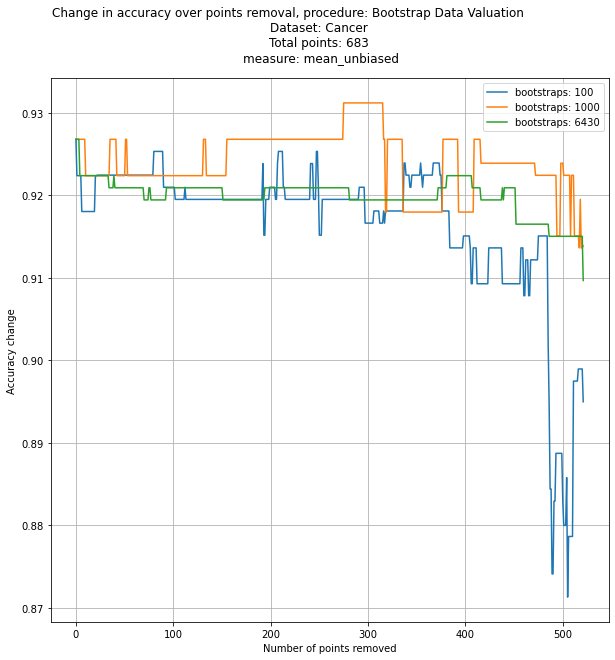

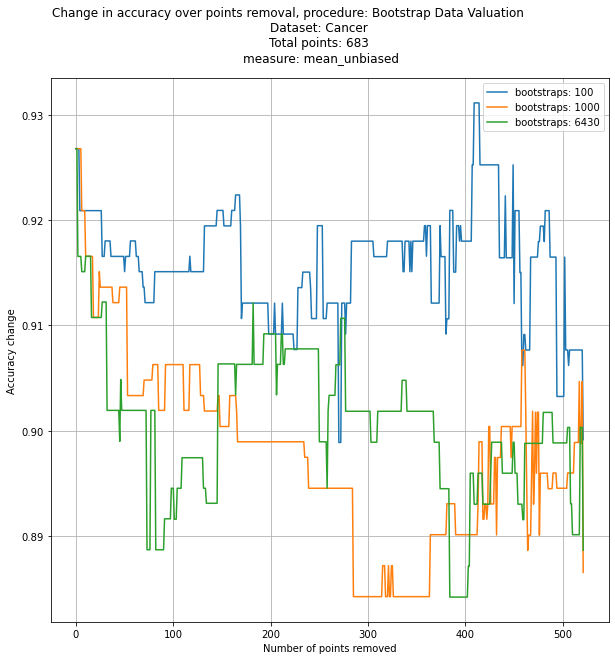

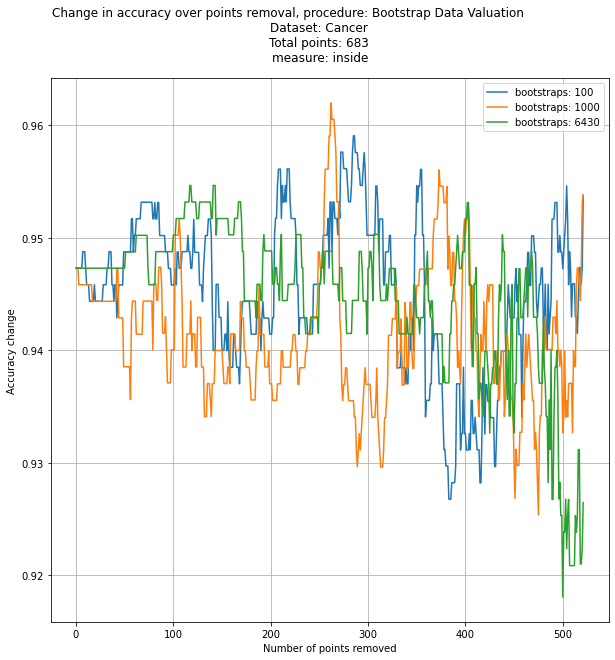

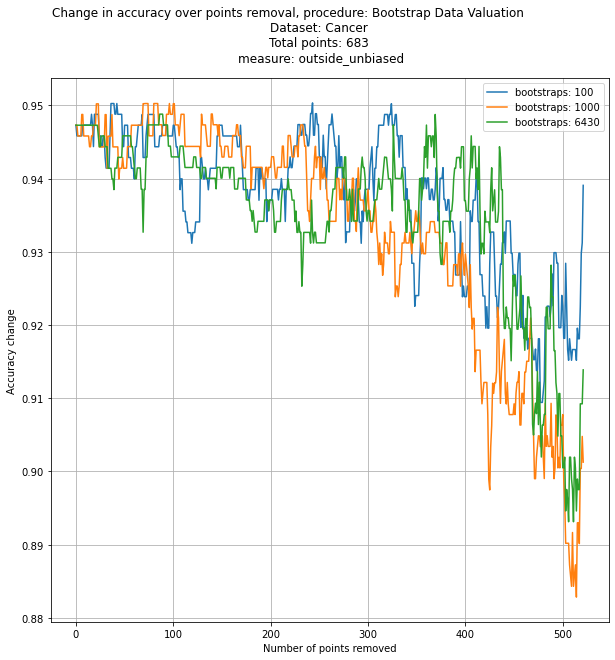

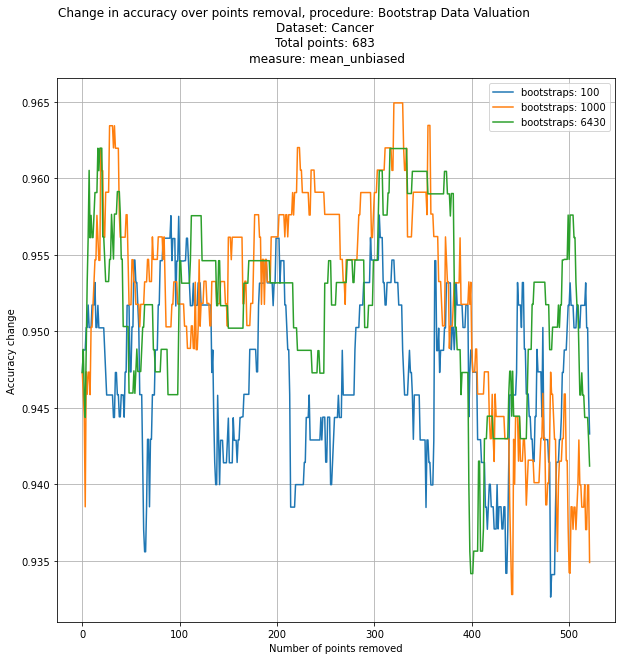

In [17]:
os.mkdir("Cancer")
os.chdir("Cancer")

features = cancer.columns[1:10].tolist()
target = "class"
dataset="Cancer"

measures = ["inside","outside_biased","outside_unbiased", "mean_biased", "mean_unbiased"]

n_points = len(cancer)
n_bootstraps=[100,1000,int(n_points*math.log(n_points,2))]
bootstraps_dict = {}

for model in models:
    os.mkdir(f"model={model.max_depth}")
    os.chdir(f"model={model.max_depth}")
    for n_b in n_bootstraps:
        valuation = bootstrap_data_valuation(cancer,
                                             model,
                                             target,
                                             n_bootstraps=n_b,
                                             n_folds=10)
        dfs = valuation.perform_kfold()
        point_valuation = valuation.point_valuation
        folds = valuation.folds
        bootstraps_dict[n_b] = {"point_valuation":point_valuation,
                                "folds": folds}
    
    create_accuracy_removal_plots(measures, 
                                  features, 
                                  target, 
                                  dataset, 
                                  n_points, 
                                  cancer, 
                                  "real",
                                  model,
                                  bootstraps_dict,
                                  param_dict=None)
    os.chdir("../")
os.chdir("../")

## Heart dataset

## LOO

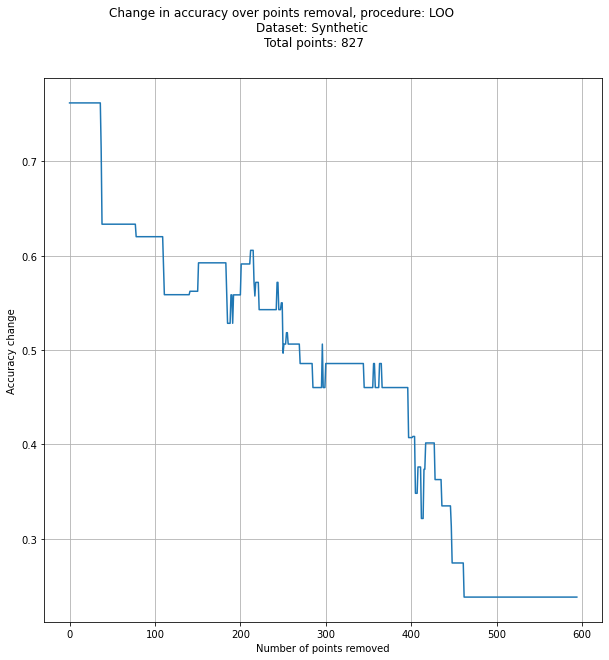

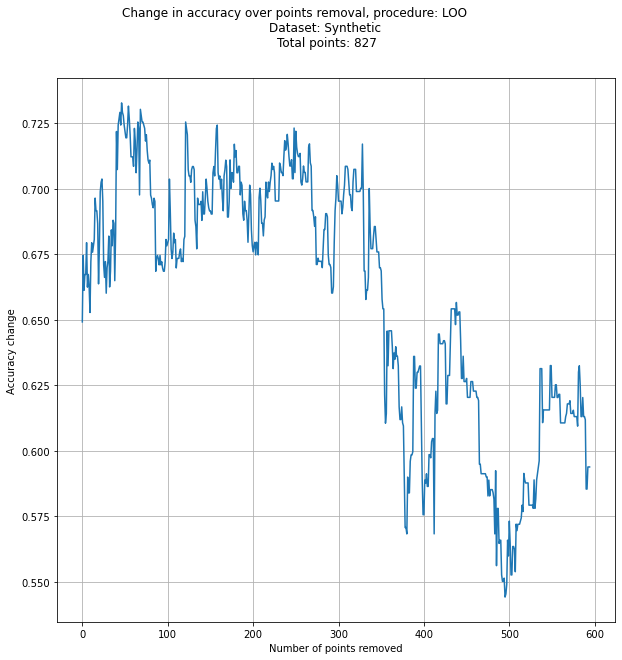

In [16]:
os.mkdir("Heart")
os.chdir("Heart")

features = heart.columns[1:13].tolist()
target = "class"
dataset = "Heart"

os.mkdir("LOO")
os.chdir("LOO")

for model in models:
    os.mkdir(f"model={model.max_depth}")
    os.chdir(f"model={model.max_depth}")
    
    df = LOO(heart, features, target, model)
    LOO_kfold(df, target, features, model, folds=5)
    os.chdir("../")
os.chdir("../")
os.chdir("../")

## Bootstrap Data Valuation

In [17]:
os.mkdir("Heart")
os.chdir("Heart")

features = heart.columns[1:13].tolist()
target = "class"
dataset="Heart"

measures = ["inside","outside_biased","outside_unbiased", "mean_biased", "mean_unbiased"]

n_points = len(heart)
n_bootstraps=[100,1000,5000]
bootstraps_dict = {}

for model in models:
    os.mkdir(f"model={model.max_depth}")
    os.chdir(f"model={model.max_depth}")
    for n_b in n_bootstraps:
        valuation = bootstrap_data_valuation(heart,
                                             model,
                                             target,
                                             n_bootstraps=n_b,
                                             n_folds=5)
        dfs = valuation.perform_kfold()
        point_valuation = valuation.point_valuation
        folds = valuation.folds
        bootstraps_dict[n_b] = {"point_valuation":point_valuation,
                                "folds": folds}
    
    create_accuracy_removal_plots(measures, 
                                  features, 
                                  target, 
                                  dataset, 
                                  n_points, 
                                  heart, 
                                  "real",
                                  model,
                                  bootstraps_dict,
                                  param_dict=None)
    os.chdir("../")
os.chdir("../")

Fold: 0
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 26.760392904281616 seconds --- 

Fold: 1
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 24.533368349075317 seconds --- 

Fold: 2
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 25.178667306900024 seconds --- 

Fold: 3
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 25.59194016456604 seconds --- 

Fold: 4
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset n

## LOO and bootstrap tests on Banknotes dataset

In [13]:
os.mkdir("Banknotes")
os.chdir("Banknotes")
noises = [0.0, 0.05, 0.15, 0.25]

features = banknotes.columns[0:4].tolist()
target = "class"

n = len(banknotes)
n_bootstraps=[100, 1000, 5000]

for noise in noises:
    os.mkdir(f"noise={noise}")
    os.chdir(f"noise={noise}")
    
    banknotes_noisy = banknotes.copy()
    noise_idx = banknotes_noisy.sample(frac=noise, random_state=18)

    banknotes_noisy = banknotes_noisy.apply(flip,
                                      idx_list=noise_idx["index"].tolist(),
                                      axis=1)

    # Test bootstrap
    real_datasets_tests_bootstrap(banknotes_noisy, noise_idx, features, target, n_bootstraps, models, "Banknotes")

    # Test LOO
    real_datasets_tests_LOO(banknotes_noisy, noise_idx, features, target, models, "Banknotes")
    
    os.chdir("../")
os.chdir("../")

Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 50
Subset number: 60
Subset number: 70
Subset number: 80
Subset number: 90
--- 64.66102433204651 seconds --- 

Subset number: 0
Subset number: 100
Subset number: 200
Subset number: 300
Subset number: 400
Subset number: 500
Subset number: 600
Subset number: 700
Subset number: 800
Subset number: 900
--- 694.6678144931793 seconds --- 

Subset number: 0
Subset number: 500
Subset number: 1000
Subset number: 1500
Subset number: 2000
Subset number: 2500
Subset number: 3000
Subset number: 3500
Subset number: 4000
Subset number: 4500
--- 5083.907185554504 seconds --- 

Creating performance graphs
Creating performance graphs
Creating performance graphs
Creating performance graphs
Creating performance graphs
Creating performance graphs
Creating performance graphs
Creating performance graphs
Subset number: 0
Subset number: 10
Subset number: 20
Subset number: 30
Subset number: 40
Subset number: 5